In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn import preprocessing
from NFLUtils import NFLUtils
import optuna
%matplotlib inline
nfl_utils = NFLUtils()

# Set torch seeds
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load CSV
cp Combined.csv ~/drive/Notes/ML/Pytorch/footballData/n

In [23]:
df = pd.read_csv("./footballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)

# Shuffle dataFrame (don't do this?)
# df = shuffle(df, random_state=101)
# df.head()
df.info()

test_performance_size = 200
test_performance_df = df[df.shape[0]-test_performance_size:]
df = df[:df.shape[0]-test_performance_size]
print(f'df after perf set removed: {df.shape}')
print(f'df perf set size {test_performance_df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4741 entries, 0 to 4740
Columns: 218 entries, Unnamed: 0 to D_datediff
dtypes: float64(142), int64(67), object(9)
memory usage: 7.9+ MB
df after perf set removed: (4541, 218)
df perf set size (200, 218)


# Columns to use
(TODO)

In [24]:
df[:5]

,Unnamed: 0,Season,Date,Home_Team,H_Q1,H_Q2,H_Q3,H_Q4,H_OT,H_Final,...,D_punting_lng,D_punting_pnt,D_punting_yds,D_scoring_fga,D_scoring_fgm,D_scoring_xpa,D_scoring_xpm,D_start_odds,D_halftime_odds,D_datediff
0,248,1999,1999-10-17,PIT,7,7,0,3,0,17,...,-4.808,-0.848,-8.640,-0.472,0.648,0.848,0.632,0.0,0.0,0.0
1,245,1999,1999-10-17,CLE,0,7,0,0,0,7,...,-2.192,2.104,105.232,-1.696,-1.952,-1.032,-1.032,0.0,0.0,1.0
2,244,1999,1999-10-17,PHI,7,13,0,0,0,20,...,3.840,3.008,154.488,-0.440,0.200,-0.808,-0.808,0.0,0.0,0.0
3,243,1999,1999-10-17,OAK,10,3,7,0,0,20,...,5.768,-0.824,-26.624,-1.544,-1.848,1.144,1.144,0.0,0.0,0.0
4,227,1999,1999-10-21,KAN,0,7,7,21,0,35,...,10.312,-1.664,-49.992,-0.728,-0.512,1.096,1.096,0.0,0.0,0.0


## 1. Separate continuous, categorical, and label column names

Pretty much everything is continuous. 

Note: the y_col is what you're trying to predict

## Feature engineering
New Columns
- **h_win**: Home team won


In [25]:
cat_cols = []
cont_cols = [
    # Home vs away days since last game
    'H_datediff', 'V_datediff',
    
    # First Downs
    'H_First_Downs', 'V_First_Downs',
    
    # Basic Stats
    'H_Rush', 'V_Rush',
    'H_Yds', 'V_Yds',
    'H_TDs', 'V_TDs',
    'H_Cmp', 'V_Cmp',
    'H_Att', 'V_Att',
    'H_Yd', 'V_Yd',
    'H_TD', 'V_TD',
    'H_INT', 'V_INT',
    'H_Sacked', 'V_Sacked',
    'H_Yards', 'V_Yards',
    'H_Net_Pass_Yards', 'V_Net_Pass_Yards',
    'H_Total_Yards', 'V_Total_Yards',
    'H_Fumbles', 'V_Fumbles',
    'H_Lost', 'V_Lost',
    'H_Turnovers', 'V_Turnovers',
    'H_Penalties', 'V_Penalties',
    #'H_Third_Down_Conv', 'V_Third_Down_Conv',
    #'H_Fourth_Down_Conv', 'V_Fourth_Down_Conv',
    #'H_Time_of_Possession', 'V_Time_of_Possession',
    
    # Passing Detailed
    'H_passing_att', 'V_passing_att',
    'H_passing_cmp', 'V_passing_cmp',
    'H_passing_int', 'V_passing_int',
    'H_passing_lng', 'V_passing_lng',
    'H_passing_sk', 'V_passing_sk',
    'H_passing_td', 'V_passing_td',
    'H_passing_yds', 'V_passing_yds',
    
    # Receiving
    'H_receiving_lng', 'V_receiving_lng',
    'H_receiving_td', 'V_receiving_td',
    'H_receiving_yds', 'V_receiving_yds',
    
    # Rushing Detailed
    'H_rushing_att', 'V_rushing_att',
    'H_rushing_lng', 'V_rushing_lng',
    'H_rushing_td', 'V_rushing_td',
    'H_rushing_yds', 'V_rushing_yds',
    
    # Defense Interceptions
    'H_def_interceptions_int', 'V_def_interceptions_int',
    'H_def_interceptions_lng', 'V_def_interceptions_lng',
    'H_def_interceptions_pd', 'V_def_interceptions_pd',
    'H_def_interceptions_td', 'V_def_interceptions_td',
    'H_def_interceptions_yds', 'V_def_interceptions_yds',
    
    # Defense Fumbles
    'H_fumbles_ff', 'V_fumbles_ff',
    'H_fumbles_fr', 'V_fumbles_fr',
    'H_fumbles_td', 'V_fumbles_td',
    'H_fumbles_yds', 'V_fumbles_yds',
    
    # Defense Tackles
    'H_sk', 'V_sk',
    'H_tackles_ast', 'V_tackles_ast',
    'H_tackles_comb', 'V_tackles_comb',
    'H_tackles_qbhits', 'V_tackles_qbhits',
    'H_tackles_solo', 'V_tackles_solo',
    'H_tackles_tfl', 'V_tackles_tfl',
    
    # Kick Returns
    'H_kick_returns_lng', 'V_kick_returns_lng',
    'H_kick_returns_rt', 'V_kick_returns_rt',
    'H_kick_returns_td', 'V_kick_returns_td',
    'H_kick_returns_yds', 'V_kick_returns_yds',
    
    # Punt Returns
    'H_punt_returns_lng', 'V_punt_returns_lng',
    'H_punt_returns_ret', 'V_punt_returns_ret',
    'H_punt_returns_td', 'V_punt_returns_td',
    'H_punt_returns_yds', 'V_punt_returns_yds',
    
    # Punting/Scoring
    'H_punting_lng', 'V_punting_lng',
    'H_punting_pnt', 'V_punting_pnt',
    'H_punting_yds', 'V_punting_yds',
    'H_scoring_fga', 'V_scoring_fga',
    'H_scoring_fgm', 'V_scoring_fgm',
    'H_scoring_xpa', 'V_scoring_xpa',
    'H_scoring_xpm', 'V_scoring_xpm',
    
    # Odds
    # 'H_start_odds', 'V_start_odds',
    # 'H_halftime_odds', 'V_halftime_odds'
]

cont_cols = [
    'D_datediff', # Days since last game (Home - visitor)
    
    # first downs
    'D_First_Downs',
    
    # Basic Stats
    'D_Rush',
    'D_Yds',
    'D_TDs',
    'D_Cmp',
    'D_Att',
    'D_Yd',
    'D_TD',
    'D_INT',
    'D_Sacked',
    'D_Yards',
    'D_Net_Pass_Yards',
    'D_Total_Yards',
    'D_Fumbles',
    'D_Lost',
    'D_Turnovers',
    'D_Penalties',
    
    # Passing Detailed
    'D_passing_att',
    'D_passing_cmp',
    'D_passing_int',
    'D_passing_lng',
    'D_passing_sk',
    'D_passing_td',
    'D_passing_yds',
    
    # Receiving
    'D_receiving_lng',
    'D_receiving_td',
    'D_receiving_yds',
    
    # Rushing Detailed
    'D_rushing_att',
    'D_rushing_lng',
    'D_rushing_td',
    'D_rushing_yds',
    
    # Defense interceptions
    'D_def_interceptions_int',
    'D_def_interceptions_lng',
    'D_def_interceptions_pd',
    'D_def_interceptions_td',
    'D_def_interceptions_yds',
    
    # Defense fumbles
    'D_fumbles_ff',
    'D_fumbles_fr',
    'D_fumbles_td',
    'D_fumbles_yds',
    
    # Defense tackles
    'D_sk',
    'D_tackles_ast',
    'D_tackles_comb',
    'D_tackles_qbhits',
    'D_tackles_solo',
    'D_tackles_tfl',
    
    # Kick Returns
    'D_kick_returns_lng',
    'D_kick_returns_rt',
    'D_kick_returns_td',
    'D_kick_returns_yds',
    
    # Punt Returns
    'D_punt_returns_lng',
    'D_punt_returns_ret',
    'D_punt_returns_td',
    'D_punt_returns_yds',
    
    # Punting / Scoring
    'D_punting_lng',
    'D_punting_pnt',
    'D_punting_yds',
    'D_scoring_fga',
    'D_scoring_fgm',
    'D_scoring_xpa',
    'D_scoring_xpm'
]


y_col = ['H_Won']
y_col_perf = ['H_Won', 'H_start_odds', 'V_start_odds', 'H_halftime_odds', 'V_halftime_odds']

# create cont_df and y_df from the df
cont_df = df[cont_cols]
y_df = df[y_col]

# test performance set
perf_conts_df = test_performance_df[cont_cols]
perf_y_df = test_performance_df[y_col_perf]

print(cont_df.dtypes)

D_datediff       float64
D_First_Downs      int64
D_Rush             int64
D_Yds              int64
D_TDs              int64
                  ...   
D_punting_yds    float64
D_scoring_fga    float64
D_scoring_fgm    float64
D_scoring_xpa    float64
D_scoring_xpm    float64
Length: 62, dtype: object


## Monotone constraints dict

In [26]:
monotone_constraints = {
    # Time between games - More rest is better
    'D_datediff': 1,
    
    # Offensive positive indicators
    'D_First_Downs': 1,
    'D_Rush': 1,
    'D_Yds': 1,
    'D_TDs': 1,
    'D_Cmp': 1,
    'D_Yd': 1,
    'D_TD': 1,
    'D_Net_Pass_Yards': 1,
    'D_Total_Yards': 1,
    
    # Negative indicators
    'D_INT': -1,
    'D_Sacked': -1,
    'D_Fumbles': -1,
    'D_Lost': -1,
    'D_Turnovers': -1,
    'D_Penalties': -1,
    
    # Passing detail - positive
    'D_passing_cmp': 1,
    'D_passing_td': 1,
    'D_passing_yds': 1,
    'D_passing_lng': 1,
    
    # Passing detail - negative
    'D_passing_int': -1,
    'D_passing_sk': -1,
    
    # Receiving/Rushing - all positive
    'D_receiving_td': 1,
    'D_receiving_yds': 1,
    'D_receiving_lng': 1,
    'D_rushing_td': 1,
    'D_rushing_yds': 1,
    'D_rushing_lng': 1,
    
    # Defense - generally positive when in your favor
    'D_def_interceptions_int': 1,
    'D_def_interceptions_td': 1,
    'D_def_interceptions_yds': 1,
    'D_fumbles_fr': 1,
    'D_fumbles_td': 1,
    'D_sk': 1,
    'D_tackles_qbhits': 1,
    'D_tackles_tfl': 1,
    
    # Special teams - positive indicators
    'D_kick_returns_td': 1,
    'D_kick_returns_yds': 1,
    'D_punt_returns_td': 1,
    'D_punt_returns_yds': 1,
    
    # Scoring - positive
    'D_scoring_fgm': 1,
    'D_scoring_xpm': 1
}

monotone_constraints_tuple = ()
no_monotone_constraints_tuple = ()
for col in cont_cols:
    monotone_constraints_tuple = monotone_constraints_tuple + (monotone_constraints[col],) if col in monotone_constraints else monotone_constraints_tuple + (0,)
    no_monotone_constraints_tuple = no_monotone_constraints_tuple + (0,)
print(monotone_constraints_tuple)
print(no_monotone_constraints_tuple)

(1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


#### 1a. Normalize cont_df
StandardScaler is instead used by the pipeline

In [27]:
# min_max_scaler = preprocessing.MinMaxScaler()
# cont_scaled = min_max_scaler.fit_transform(cont_df.values)
# cont_df = pd.DataFrame(cont_scaled)
# cont_df.head()

# # test performance set
# perf_conts_df_scaled = min_max_scaler.fit_transform(perf_conts_df.values)
# perf_conts_df = pd.DataFrame(perf_conts_df_scaled)

### 3. Create an array of continuous values
Numpy array 'conts' containing stack of each continuous column

In [28]:
conts = np.stack([cont_df[col].values for col in list(cont_df.columns)], 1)
conts[:5]

y_col = np.stack([y_df[col].values for col in y_col], 1)

# test performance set
perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)

### 4. Convert conts to tensor

In [29]:
print(conts.shape)
print(y_col.shape)

(4541, 62)
(4541, 1)


In [30]:
# Handled by model.fit()
# conts = torch.tensor(conts, dtype=torch.float32)
# y_col = torch.tensor(y_col, dtype=torch.float32)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import logging
# Set up logging
logging.basicConfig(level=logging.INFO)

In [32]:
class TabularModel(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, n_cont, out_sz, layer_shape, p=0.5, criterion=nn.BCELoss(),
                optimizer_class=torch.optim.Adam, lr=0.001, n_epochs=10, confidence_threshold=0.1):
        super().__init__()
        # Model architecture params
        self.layer_shape = layer_shape
        self.n_cont = n_cont
        self.out_sz = out_sz
        self.p = p
        self.lr = lr
        
        # Training params
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.n_epochs = n_epochs
        self.confidence_threshold = confidence_threshold
        
        # BatchNorm layer for continuous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Variable that holds the list of layers
        layerlist = []
        n_in = n_cont # no embed again
        # Iterate through the passed in "layers" parameter (ie, [200,100]) to build a list of layers
        for i, width in enumerate(self.layer_shape):
            # First layer gets special treatment
            if i == 0:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p/2)  # Less dropout in earlier layers
                ])
            else:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p)
                ])
            n_in = width
        # layerlist.append(nn.Linear(layers[-1], out_sz))
        
        # Final layer
        layerlist.extend([
            nn.Linear(self.layer_shape[-1], out_sz),
            # nn.Sigmoid()  # Ensures output between 0 and 1
        ])
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cont):
        x_cont = self.bn_cont(x_cont)  # Normalize the incoming continuous data
        x = self.layers(x_cont)        # Set up model layers
        return x
    
    def fit(self, X, y):
        """
        For sklearn pipeline
        """
        # Convert X,y to torch.tensor if needed
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)
        
        # Initialize optimizer
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        
        # Training loop
        self.train()
        for _ in range(self.n_epochs):
            optimizer.zero_grad()
            y_pred = self.forward(X)
            loss = self.criterion(y_pred, y)
            loss.backward()
            optimizer.step()

        return self
    
    def predict_proba(self, X):
        self.eval()
        with torch.no_grad():
            if not isinstance(X, torch.Tensor):
                X = torch.FloatTensor(X)
            return self(X).numpy()
        
    def predict(self, X):
        probas = self.predict_proba(X)
        return probas
        # return (probas > 0.5).astype(np.int32)
    
    def score(self, X, y):
        """        
        12/5 - this isn't called at all if 'scoring' is defined
        """
        probas = self.predict(X)
        # First apply confidence thresholding
        mask = (probas < 0.5 - self.confidence_threshold) | (probas > 0.5 + self.confidence_threshold)
        predictions = np.where(mask, (probas > 0.5).astype(np.int32), np.nan)

        # Use numpy mask for nan values
        valid_mask = ~np.isnan(predictions)
        valid_predictions = predictions[valid_mask]
        valid_targets = y[valid_mask]
        
        # Apply f1 score
        score = f1_score(valid_predictions.flatten(), valid_targets)
        return np.mean(score)

### 5. Create training set from cats, conts, and y
dont need testing set since we're running cross validation

cats currently is unused

don't need holdout set since we have a performance set

minMaxScaler replaced with StandardScaler

In [33]:
conts_train = conts
y_train = y_col

In [34]:
model = TabularModel(
    n_cont=conts.shape[1],
    out_sz=1,
    layer_shape=[8,4],
    p=0.2,     # Dropout
    criterion=nn.MSELoss(),
    optimizer_class=torch.optim.Adam,
    lr= 1e-4   # Learning rate 
)

pipeline = Pipeline([
    ('scaler', StandardScaler()), # Standardize the numerical features
    # ('regressor', LinearRegression()), # Apply a regression model
    ('model', model)
])

# print(type(conts))
# print(y_train.shape)

# scores = cross_val_score(pipeline, conts_train, y_train, cv=5, scoring='f1')
scores = cross_val_score(pipeline, conts_train, y_train, cv=5)
print(scores)
scores = np.mean(scores)
print(float(scores))

[0.         0.         0.03215434 0.         0.        ]
0.006430868167202572


### Hyperparameter search using optuna

In [35]:
# Number of epochs
n_train_iter = 1000

def objective(trial):
    # --- Suggest hyperparameters ---
    criterion = trial.suggest_categorical('criterion', nfl_utils.map_losses(None).keys())
    first_layer_size = trial.suggest_categorical('first_layer_size', [56, 48, 32, 16, 12])
    min_layers = math.floor(math.sqrt(first_layer_size))
    num_layers = trial.suggest_int('num_layers', 2, min_layers)
    confidence_threshold = trial.suggest_float('confidence_threshold', 0, 0.10)
    layer_shape = [first_layer_size]
    for i in range(1, num_layers):
        layer_shape.append(first_layer_size//(2*i))
    
    n_epochs = trial.suggest_int('n_epochs', 300, 700)
    model = TabularModel(
        n_cont=conts.shape[1],
        out_sz=1,
        layer_shape=layer_shape,
        p=trial.suggest_float('dropout', 0.28, 0.38),     # Dropout
        criterion=nfl_utils.map_losses(criterion),
        optimizer_class=torch.optim.Adam,
        lr=trial.suggest_float('lr', 1e-3, 1e-2, log=True),   # Learning rate 
        n_epochs=n_epochs,
        confidence_threshold=confidence_threshold
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Standardize the numerical features
        # ('regressor', LinearRegression()), # Apply a regression model
        ('model', model)
    ])
 
    scores = cross_val_score(pipeline, conts_train, y_train,cv=5)
    scores = float(np.mean(scores))
    trial.report(scores, n_epochs)
            
    return scores
            
def print_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")
    print(f"Best trial so far: {study.best_trial.number}, value: {study.best_trial.value}")

In [36]:
study = optuna.create_study(
    direction='maximize',   # max because using f1
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=n_train_iter
    )
)
# Uncomment to run
if False:
    study.optimize(objective, n_trials=2000, callbacks=[print_callback])
    # study.optimize(objective, n_trials=3)
    print("Best trial:")
    trial = study.best_trial
    print("Value: ", trial.value)
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
        
        

[I 2024-12-07 20:26:41,663] A new study created in memory with name: no-name-0293e669-7727-4809-8376-a97617d0334c


Value:  0.37491718013436764

Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 39
    dropout: 0.47875406200808335
    lr: 0.009997751942238913
    


Value:  0.3759073484440955
Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 68
    dropout: 0.4497689844977892
    lr: 0.007977206154472633
    
    
    
12/6

Trial 206 finished with value: 0.547218605316966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.05966702820817666, 'n_epochs': 379, 'dropout': 0.36961850006275193, 'lr': 0.008649806179332952}. Best is trial 206 with value: 0.547218605316966.

[I 2024-12-06 12:49:28,047] Trial 579 finished with value: 0.5335308702482566 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.059979796814548306, 'n_epochs': 481, 'dropout': 0.2511747953677191, 'lr': 0.007942836869449217}. Best is trial 579 with value: 0.5335308702482566.


[I 2024-12-06 14:53:00,850] Trial 385 finished with value: 0.5547767877242975 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.003263372268063613, 'n_epochs': 300, 'dropout': 0.3153661030384182, 'lr': 0.00593138298730814}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:32:38,969] Trial 583 finished with value: 0.550872165273167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.010458110701511005, 'n_epochs': 336, 'dropout': 0.3188974735143638, 'lr': 0.006976522077116529}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:55:26,133] Trial 669 finished with value: 0.5645423555160363 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0243907527056759, 'n_epochs': 370, 'dropout': 0.32998724447261185, 'lr': 0.0075018456671685696}. Best is trial 669 with value: 0.5645423555160363.

[I 2024-12-06 20:33:46,555] Trial 1737 finished with value: 0.5716002919237433 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.015368961704784596, 'n_epochs': 328, 'dropout': 0.348927921024466, 'lr': 0.009575624984802092}. Best is trial 1737 with value: 0.5716002919237433.


[I 2024-12-06 21:17:06,545] Trial 1889 finished with value: 0.5739803740995499 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.014029751567812504, 'n_epochs': 357, 'dropout': 0.34275064196127053, 'lr': 0.008692336113071646}. Best is trial 1889 with value: 0.5739803740995499.



In [37]:
# best_params = study.best_trial.params

best_params_ignore = {
    "first_layer_size": 8,
    "num_layers": 2,
    "n_epochs": 39,
    "dropout": 0.47875406200808335,
    "lr": 0.009997751942238913
}
# F1 Best trial so far: 151, value: 0.5520542963226872
best_paramsaa = {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'n_epochs': 450, 'dropout': 0.3221038268805969, 'lr': 0.0033495207923573745, 'confidence_threshold': 0}
best_params = {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.014029751567812504, 'n_epochs': 357, 'dropout': 0.34275064196127053, 'lr': 0.008692336113071646}
best_params = {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.015368961704784596, 'n_epochs': 328, 'dropout': 0.348927921024466, 'lr': 0.009575624984802092}

print(best_params)
layer_shape = [best_params['first_layer_size']]
for i in range(1, best_params['num_layers']):
    layer_shape.append(best_params['first_layer_size']//(2*i))
model = TabularModel(
    n_cont=conts.shape[1],
    out_sz=1,
    layer_shape=layer_shape,
    p=best_params['dropout'],     # Dropout
    criterion=nfl_utils.map_losses(best_params['criterion']),
    optimizer_class=torch.optim.Adam,
    lr=best_params['lr'],   # Learning rate 
    n_epochs=best_params['n_epochs'],
    confidence_threshold=best_params['confidence_threshold']
)

pipeline = Pipeline([
    ('scaler', StandardScaler()), # Standardize the numerical features
    # ('regressor', LinearRegression()), # Apply a regression model
    ('model', model)
])

pipeline.fit(conts_train, y_train)
probas = pipeline.predict(perf_conts)
confidence_threshold = best_params['confidence_threshold']

{'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.015368961704784596, 'n_epochs': 328, 'dropout': 0.348927921024466, 'lr': 0.009575624984802092}


In [38]:
# Remove outside of confidence threshold
mask = (probas < 0.5 - confidence_threshold) | (probas > 0.5 + confidence_threshold)
predictions = np.where(mask, probas, np.nan)

# Use numpy mask for nan values
valid_mask = ~np.isnan(predictions)
valid_predictions = predictions[valid_mask]
valid_mask = valid_mask.flatten()
perf_y_col_mask = perf_y_col[valid_mask]


true_values = perf_y_col_mask[:,0].astype(np.int32)
pred_values = valid_predictions.flatten()
pred_values_int = np.rint(valid_predictions).flatten().astype(np.int32)

model_win_prob = (1.0*(true_values == pred_values_int).sum()) / (true_values.shape[0])
print(model_win_prob)

0.6071428571428571


model wn prob 0.6071428571428571
won odss is 3.5680488734634666
prediction_decimal 0.5460525751113892 model_prediction_decimal 0.09210515022277832
kelly_res: 0.16734623244649793 model_win_prob: 0.6071428571428571  won_odds:3.5680488734634666 account_val: 100
won odss is 2.170120176810667
prediction_decimal 0.4618756175041199 model_prediction_decimal 0.07624876499176025
kelly_res: 0.038346625170989856 model_win_prob: 0.6071428571428571  won_odds:2.170120176810667 account_val: 104.29753303712585
won odss is 1.3232701161813334
prediction_decimal 0.5460525751113892 model_prediction_decimal 0.09210515022277832
kelly_res: -0.14186748272210797 model_win_prob: 0.6071428571428571  won_odds:1.3232701161813334 account_val: 104.76551773480054
won odss is 1.4749278758613331
prediction_decimal 0.5460525751113892 model_prediction_decimal 0.09210515022277832
kelly_res: -0.09133043684355285 model_win_prob: 0.6071428571428571  won_odds:1.4749278758613331 account_val: 104.28504717102403
won odss is 4.162

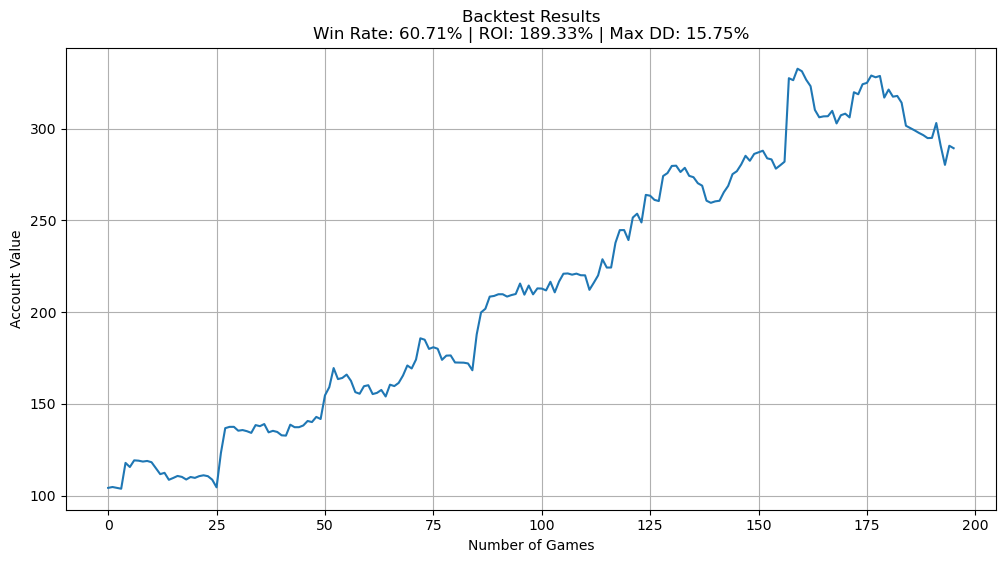

{'final_value': 289.32642019551275,
 'roi': 1.8932642019551276,
 'win_rate': 0.6071428571428571,
 'max_drawdown': 0.15749230815365048,
 'total_bets': 196}

In [39]:
nfl_utils.backtest_model(pipeline, perf_conts, perf_y_col, initial_capital=100, position_size=0.1, confidence_threshold=best_params['confidence_threshold'], show_plot=True)
# backtest_model(pipeline, perf_conts, perf_y_col, initial_capital=100, position_size=0.1, confidence_threshold=best_params['confidence_threshold'], show_plot=True)

# Using XGBoost

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns # confusion matrix

In [20]:
conts_train.shape

(4541, 62)

In [21]:
# Fit the model
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],           # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3, 6, 9],                      # Simplified to 3 values, covering shallow to deep
    'n_estimators': [100, 200],                  # Removed extremes, these are most common sweet spots
    'subsample': [0.8, 1.0],                     # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.8, 1.0],              # Same as above
    'min_child_weight': [1, 3],                  # Removed 5 as it might be too restrictive
    'monotone_constraints': [monotone_constraints_tuple, no_monotone_constraints_tuple]
}


model = XGBClassifier(eval_metric='logloss')

# Tune hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1)
grid_search.fit(conts_train, y_train)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


KeyboardInterrupt: 

In [ ]:
print(grid_search.best_params_)
# No monotone constraints
# 60.15%, {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
# 65% {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

# Monotone constraints
# {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'monotone_constraints': (1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1), 'n_estimators': 200, 'subsample': 1.0}

In [ ]:

# train final model w/ early stopping
model = XGBClassifier(
    eval_metric='logloss',
    early_stopping_rounds=10,
    # **grid_search.best_params_
    # **{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
    # **{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'monotone_constraints': (1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1), 'n_estimators': 90, 'subsample': 1.0},
    
    **{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'monotone_constraints': (1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1), 'n_estimators': 200, 'subsample': 1.0}

)
model.fit(
    conts_train,
    y_train,
    eval_set=[(conts_train, y_train)], # , (holdout_conts, holdout_y)
    verbose=True
)

In [ ]:
# Make predictions for test data
# model = grid_search.best_estimator_
y_pred = model.predict(perf_conts)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(perf_y_col[:,0], predictions)

nfl_utils.backtest_model(model, perf_conts, perf_y_col, initial_capital=1000, position_size=0.1, 
                   confidence_threshold=0, show_plot=True)

In [ ]:
# Make confusion matrix
cm = confusion_matrix(perf_y_col[:,0], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Test against performance data (includes odds)
